# Part 2: Resolution issues in solar wind ion distributions
In this final example we will look at how instrument resolution can limit our ability to resolve the solar wind ion beam.

In [12]:
# IPython magics
%matplotlib inline

In [13]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage



## Maxwell-Boltzmann distribution
Measurement of 1D particle energy distributions. The canonical Maxwell-Boltzmann distribution
is given by:

\\( f(v) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{mv^2}{2k_BT}\right) \\)

where m is the mass of the species, n is the (number) density, k<sub>B</sub>T is the temperature, and v is the speed at which we are looking for the distribution function. Here we will use a "drifting Maxwellian" which is a Maxwell-Boltzmann distribution that is moving at a relative velocity to the frame of the distribution.

\\( f(\mathbf{v}) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{m(\mathbf{v_0}-\mathbf{v})^2}{2k_BT}\right) \\)

We also need to convert the distribution function to units of differential number flux, also known as DNF [m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>], and differential energy flux, also known as DEF [J m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>]. Note that the "J/J" part of the DEF units is retained to indicate DEF and to avoid ambiguity.

\\( J_N = f\frac{v^2}{m} \\)  
\\( J_E = f\frac{v^4}{2m} \\)

In our code we will implement the drifting Maxwellian and conversions as a Python lambda functions.

In [14]:
# Distribution function for a drifting isotropic Maxwell-Boltzmann distribution with density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_mb(m, q, n, v0, th0, ph0, kT, EperQ, th, ph):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
#x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    return n*((m*consts.u/(2*np.pi*kT*consts.e))**(1.5))*np.exp(-x/(kT*consts.e))

# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
todnf = lambda f, EperQ, m, q: f*EperQ*consts.e*2*(q/(m*consts.u))**2
todef = lambda f, EperQ, m, q: f*((EperQ*consts.e)**2)*q*2*(q/(m*consts.u))**2

Generate a solar wind spectrum with H+ and He++ moving at 450 km/s with a temperature of 10 eV. We build a distribution before we do this.

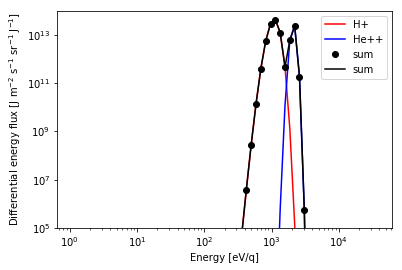

In [15]:
# Define some parameters of the energy table and geometric/calibration factor.
energy_resolution = 0.18
num_energy_bins = 64
energy_table_lower = np.zeros(num_energy_bins)
energy_table_upper = np.zeros(num_energy_bins)
energy_table_lower[0] = 1.0
energy_table_upper[0] = 1.0*(1+1*energy_resolution)
for i in range(1,num_energy_bins):
    energy_table_lower[i] = energy_table_upper[i-1]
    energy_table_upper[i] = energy_table_lower[i]*(1+1*energy_resolution)
energy_table_centre = (energy_table_upper+energy_table_lower)/2.0
G = 5e-10
quantumeff = lambda E, scale=10000: np.exp(-(E/10000)**2)
taua = 1.0

f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, energy_table_centre, 0.0, 0.0)
f_he = dist_mb(4.00260325415, 2.0, 1e6*0.04, 450.0,0.0,0.0, 10.0, energy_table_centre, 0.0, 0.0)
#plt.loglog(energy_table_centre, todef(f_h,energy_table_centre,1.007825032241,1.0),'or')
plt.loglog(energy_table_centre, todef(f_h,energy_table_centre,1.007825032241,1.0),'-r', label='H+')
#plt.loglog(energy_table_centre,todef(f_he,energy_table_centre,4.00260325415,2.0),'ob')
plt.loglog(energy_table_centre,todef(f_he,energy_table_centre,4.00260325415,2.0),'-b', label='He++')
plt.loglog(energy_table_centre, todef(f_h,energy_table_centre,1.007825032241,1.0)+todef(f_he,energy_table_centre,4.00260325415,2.0),'ok', label='sum')
plt.loglog(energy_table_centre, todef(f_h,energy_table_centre,1.007825032241,1.0)+todef(f_he,energy_table_centre,4.00260325415,2.0),'-k', label='sum')
plt.xlabel('Energy [eV/q]')
plt.ylim([1e5,1e14])
plt.ylabel('Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')
plt.legend()


Here the speed of the solar wind, combined with the low temperature produces a very narrow beam in energy. To properly forward-model this we need to account for the finite width of each energy bin.

Now lets look at the counts across a single energy/charge bin - we will see that it will vary over the bin width

Value for bin 40 using 20 sub-samples gives value of 3277.026996127254


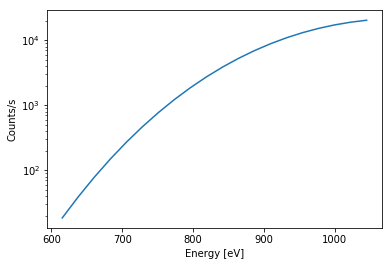

In [16]:
# Bin number, and now many sub-samples to take
i = 40
n = 20

# Instrument response is modelled as a Gaussian.
fwhm = energy_table_upper[i]-energy_table_lower[i]
sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
tmp_energies = np.linspace(energy_table_lower[i]*(1-energy_resolution),energy_table_upper[i]*(1+energy_resolution),n)
inst_response = np.exp(-0.5*((tmp_energies-energy_table_centre[i])/sig)**2)/(sig*np.sqrt(2*np.pi))

# Calculate the efficiency at each sub-sample energy
eps = quantumeff(tmp_energies)

# Get the distribution at each sub-sample energy
f_h = dist_mb(1.007825032241, 1.0, 1e6*(1-0.04), 450.0,0.0,0.0, 10.0, tmp_energies, 0.0, 0.0)

plt.semilogy(tmp_energies, todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps)
plt.xlabel('Energy [eV]')
plt.ylabel('Counts/s')

# We need the delta in energy to numerical integrate the combination of the count profile across the energy bin
# and the instrument response.
de_tmp_energies = (np.max(tmp_energies)-np.min(tmp_energies))/n
print('Value for bin {} using {} sub-samples gives value of {}'.format(i,n,np.sum(inst_response*todef(f_h,tmp_energies,1.007825032241,1.0)*G*eps*de_tmp_energies)))


To use this in an easy way for each bin, we capture this in a function that returns the counts for a single bin.

In [17]:
# This function returns the counts in a single bin for an under-resolved population.
def underresolve(fun, E_low, E_up, E_c, dEoverE, n=20):
    fwhm = E_up-E_low
    sig = fwhm/(2.0*np.sqrt(2.0*np.log(2)))
    tmp_energies = np.linspace(E_low*(1-dEoverE), E_up*(1+dEoverE), n)
    de_tmp_energies = (E_up*(1+dEoverE)-E_low*(1-dEoverE))/n
    inst_response = np.exp(-0.5*((tmp_energies-E_c)/sig)**2)/(sig*np.sqrt(2*np.pi))
    return np.sum(inst_response*fun(tmp_energies)*de_tmp_energies)


## Synthetic under-resolved spectrum
Finally, we can fully sample the analytic spectrum, taking into account the sub-optimal resolution then plot to examine it.

Text(0,0.5,'Counts/accumulation')

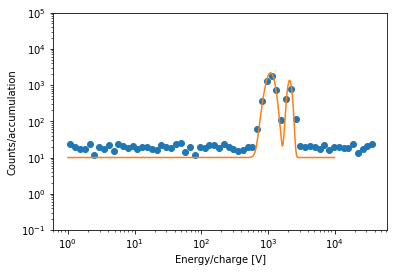

In [18]:
# Calculate the counts/accumulation (C) with a noise level (noise, counts/accumulation)
noise = 10
R = np.zeros(num_energy_bins)
deffun = lambda E: (todef(dist_mb(1.007825032241, 1.0, 1e5*(1-0.04), 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,1.007825032241,1.0) +
                        todef(dist_mb(4.00260325415, 2.0, 1e5*0.04, 450.0,0.0,0.0, 10.0, E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)
for i in range(num_energy_bins):
    R[i] = underresolve(deffun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)

# Sample with the noise.
C = np.random.poisson(R*taua + noise)

# Generate a high resolution spectrum for comparison
E_hi = np.logspace(0,4,400)
def_hi = deffun(E_hi)*taua
    
plt.loglog(energy_table_centre,C+noise,'o')
plt.loglog(E_hi,def_hi+noise)
plt.ylim([1e-1,1e5])
plt.xlabel('Energy/charge [V]')
plt.ylabel('Counts/accumulation')

## Let's try to fit this - using all the ingredients but using a different fitting method

Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=103000.0 n_he=10300.0 v=450.0 kT=20.599999999999994 bg=5.149999999999999
Step: n_h=105341.6533248 n_he=9988.75824768 v=450.90096672 kT=20.923713064959998 bg=5.156798826239999
Step: n_h=106659.44742912002 n_he=10298.620769792 v=451.038173568 kT

Step: n_h=183516.76027825422 n_he=7608.411975432595 v=447.2966093966076 kT=16.910916645747157 bg=3.9763266435985
Step: n_h=183516.76027825422 n_he=7608.411975432595 v=447.2966093966076 kT=16.910916645747157 bg=3.9763266435985
Step: n_h=183516.76027825422 n_he=7608.411975432595 v=447.2966093966076 kT=16.910916645747157 bg=3.9763266435985
Step: n_h=181063.82774900034 n_he=7720.83826100998 v=447.3650033309998 kT=16.764544451815127 bg=4.136064104669009
Step: n_h=181063.82774900034 n_he=7720.83826100998 v=447.3650033309998 kT=16.764544451815127 bg=4.136064104669009
Step: n_h=181893.8381450684 n_he=7692.362596926814 v=446.977296911979 kT=16.701450627267512 bg=4.112090523305625
Step: n_h=181893.8381450684 n_he=7692.362596926814 v=446.977296911979 kT=16.701450627267512 bg=4.112090523305625
Step: n_h=181893.8381450684 n_he=7692.362596926814 v=446.977296911979 kT=16.701450627267512 bg=4.112090523305625
Step: n_h=181334.77821182774 n_he=7557.61333289944 v=447.4196046869612 kT=16.623867426224976 b

Step: n_h=98201.4861253173 n_he=3902.3571243931005 v=450.92208006349813 kT=10.229664256014285 bg=15.947240858408177
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194 kT=10.23570426504138 bg=15.936179923370736
Step: n_h=98248.37190618308 n_he=3909.7601261644204 v=450.88996016247194

Step: n_h=99015.01707041252 n_he=3974.202977923551 v=450.7338636607799 kT=10.254846533105791 bg=15.105993765557493
Step: n_h=99079.27976570261 n_he=3954.311424273039 v=450.6995096389429 kT=10.262876727474968 bg=15.233774267258095
Step: n_h=99079.27976570261 n_he=3954.311424273039 v=450.6995096389429 kT=10.262876727474968 bg=15.233774267258095
Step: n_h=99970.25467836697 n_he=4001.633534471801 v=450.6337681246772 kT=10.323438678301812 bg=14.817725506841384
Step: n_h=99970.25467836697 n_he=4001.633534471801 v=450.6337681246772 kT=10.323438678301812 bg=14.817725506841384
Step: n_h=99299.9145192944 n_he=3970.6066569447594 v=450.7714825926437 kT=10.272022338090302 bg=14.979127406319527
Step: n_h=99299.9145192944 n_he=3970.6066569447594 v=450.7714825926437 kT=10.272022338090302 bg=14.979127406319527
Step: n_h=99299.9145192944 n_he=3970.6066569447594 v=450.7714825926437 kT=10.272022338090302 bg=14.979127406319527
Step: n_h=100159.62933764356 n_he=3981.769007807852 v=450.6138594946033 kT=10.33

Step: n_h=98865.43208206221 n_he=3949.5747220317367 v=450.8432748832572 kT=10.247623359712005 bg=9.7568656754754
Step: n_h=98865.43208206221 n_he=3949.5747220317367 v=450.8432748832572 kT=10.247623359712005 bg=9.7568656754754
Step: n_h=98844.9870873943 n_he=3946.9535990900476 v=450.84970596199105 kT=10.246797370881477 bg=9.733560123653866
Step: n_h=98844.9870873943 n_he=3946.9535990900476 v=450.84970596199105 kT=10.246797370881477 bg=9.733560123653866
Step: n_h=98891.67570638502 n_he=3949.447543471724 v=450.8480832922879 kT=10.249508339895621 bg=9.732531301597014
Step: n_h=98891.67570638502 n_he=3949.447543471724 v=450.8480832922879 kT=10.249508339895621 bg=9.732531301597014
Step: n_h=98891.67570638502 n_he=3949.447543471724 v=450.8480832922879 kT=10.249508339895621 bg=9.732531301597014
Step: n_h=98871.29285154495 n_he=3949.0750397818592 v=450.8457193336065 kT=10.248265395974364 bg=9.753046395523967
Step: n_h=98871.29285154495 n_he=3949.0750397818592 v=450.8457193336065 kT=10.248265395

Step: n_h=98866.2579142072 n_he=3948.2408260220986 v=450.84699341172484 kT=10.247848196495369 bg=9.735844603989873
Step: n_h=98866.3170625163 n_he=3948.2426794919575 v=450.8469895100775 kT=10.247852509450817 bg=9.735845598946204
Step: n_h=98866.29187115861 n_he=3948.2415310761353 v=450.84699526067396 kT=10.247851397619991 bg=9.735862599002802
Step: n_h=98866.26193620136 n_he=3948.240169114485 v=450.84699719867444 kT=10.247848411424012 bg=9.73585690870799
Step: n_h=98866.2492710029 n_he=3948.239850182636 v=450.84699537716176 kT=10.247847974408428 bg=9.735863176690387
Step: n_h=98866.2492710029 n_he=3948.239850182636 v=450.84699537716176 kT=10.247847974408428 bg=9.735863176690387
Step: n_h=98866.30940795931 n_he=3948.2415341466635 v=450.84699411177655 kT=10.247852504089071 bg=9.735859997254801
Step: n_h=98866.30940795931 n_he=3948.2415341466635 v=450.84699411177655 kT=10.247852504089071 bg=9.735859997254801
Step: n_h=98866.27547925929 n_he=3948.2404846255113 v=450.84699283767094 kT=10.24

Text(0,0.5,'Counts/accumulation')

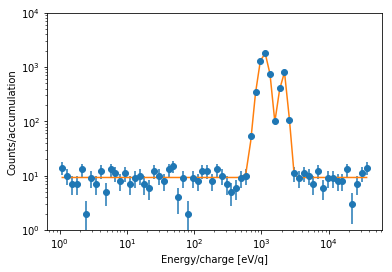

In [22]:
# Function to calculate a spectrum given the parameters in the matrix p
def spec(p):
    tmpfun = lambda E: (todef(dist_mb(1.007825032241, 1.0, p[0], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,1.007825032241,1.0) +
         todef(dist_mb(4.00260325415, 2.0, p[1], p[2],0.0,0.0, p[3], E, 0.0, 0.0),E,4.00260325415,2.0))*G*quantumeff(E)+p[4]

    f = np.zeros(num_energy_bins)
    for i in range(num_energy_bins):
        f[i] = underresolve(tmpfun, energy_table_lower[i], energy_table_upper[i], energy_table_centre[i], energy_resolution)

    return f

# Calculate the cost function.
def fitfun(p):
    return np.sqrt(np.sum((spec(p)-C)**2))

# Perform the fit. Notice this is iterative and that the noise level has been included as a fifth parameter
p0 = [1e5,1e4,500,20,5]
p = scipy.optimize.fmin(fitfun, p0, disp=True, callback=lambda p: print('Step: n_h={} n_he={} v={} kT={} bg={}'.format(p[0],p[1],p[2],p[3],p[4])))
print('n(H+)={} [actual {}]'.format(p[0],1e5*(1-0.04)))
print('n(He++)={} [actual {}]'.format(p[1],1e5*0.04))
print('v={} [actual {}]'.format(p[2],450.0))
print('T={} [actual {}]'.format(p[3],10.0))
print('Background={} [actual {}]'.format(p[4],noise))

# Plot the result
plt.errorbar(energy_table_centre,C,yerr=np.sqrt(C),fmt='o')
plt.loglog(energy_table_centre,spec(p)*taua)
plt.ylim([1,10000])
plt.xlabel('Energy/charge [eV/q]')
plt.ylabel('Counts/accumulation')


## Explore the chi-square space in the dimension of velocity and temperature
What we should also do is look at the chi^2 space for the fit. Notice here that the minimum surface (in v,T) is very narrow in velocity but broader in temperature. This means that the temperature is less constrained (a result of resolution problems).

Calculating: step 1/50
Calculating: step 2/50
Calculating: step 3/50
Calculating: step 4/50
Calculating: step 5/50
Calculating: step 6/50
Calculating: step 7/50
Calculating: step 8/50
Calculating: step 9/50
Calculating: step 10/50
Calculating: step 11/50
Calculating: step 12/50
Calculating: step 13/50
Calculating: step 14/50
Calculating: step 15/50
Calculating: step 16/50
Calculating: step 17/50
Calculating: step 18/50
Calculating: step 19/50
Calculating: step 20/50
Calculating: step 21/50
Calculating: step 22/50
Calculating: step 23/50
Calculating: step 24/50
Calculating: step 25/50
Calculating: step 26/50
Calculating: step 27/50
Calculating: step 28/50
Calculating: step 29/50
Calculating: step 30/50
Calculating: step 31/50
Calculating: step 32/50
Calculating: step 33/50
Calculating: step 34/50
Calculating: step 35/50
Calculating: step 36/50
Calculating: step 37/50
Calculating: step 38/50
Calculating: step 39/50
Calculating: step 40/50
Calculating: step 41/50
Calculating: step 42/50
C

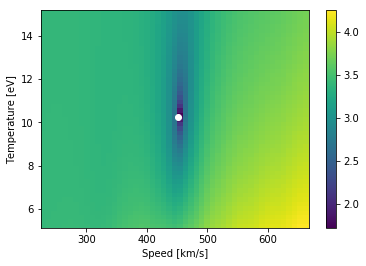

In [23]:
vx = np.arange(0.5,1.5,0.02)*p[2]
Tx = np.arange(0.5,1.5,0.02)*p[3]
rms = np.zeros((len(vx),len(Tx)))
for iy in range(len(Tx)):
    print('Calculating: step {}/{}'.format(iy+1,len(Tx)))
    for ix in range(len(vx)):
        rms[ix,iy] = fitfun([p[0],p[1],vx[ix],Tx[iy],p[4]])
plt.pcolor(vx,Tx,np.log10(rms.T))
plt.plot([p[2]],[p[3]],'ow')
plt.xlabel('Speed [km/s]')
plt.ylabel('Temperature [eV]')
plt.colorbar()